# 02. Preprocess

## Takeaways
* Drop users with few forum posts.
* Drop suspicious users often posting spam messages.
* Drop short forums by the absolute lengths.
* Drop forums without medals.
* Keep forums by famous GMs' average word count.

In [1]:
from pathlib import Path

import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

In [2]:
DATA_PATH = Path("./data/processed/")

class CFG:
    save = True

In [3]:
df = pl.read_parquet(DATA_PATH / "forums.pqt")

# Drop empty forums with missing `Message` and `RawMarkdown`
n1 = len(df)
df = (
    df
    .with_columns(
        pl.col("Message").str.len_chars().alias("msg_len"),
        pl.col("RawMarkdown").str.len_chars().alias("rawmd_len"),
    )
    .filter((pl.col("msg_len") != 0) | (pl.col("rawmd_len") != 0))
)
print(f"{n1 - len(df)} empty forums are dropped.")

5256 empty forums are dropped.


## 1. Filter Forums by #Forums per User

There exist forums without user names. The others are our familiar Kaggle legends, e.g., Chris, CPMP, etc.

In [4]:
n_forums_per_user = (
    df
    .group_by("UserName")
    .len()
    .rename({"len": "n_forums"})
)
print(f"#Users {len(n_forums_per_user)} | Min #Forums {n_forums_per_user['n_forums'].min()} | Max #Forums {n_forums_per_user['n_forums'].max()}\n")
print(f">>> Top5 <<<")
n_forums_per_user.sort(pl.col("n_forums"), descending=True).head(5)

#Users 252497 | Min #Forums 1 | Max #Forums 27305

>>> Top5 <<<


UserName,n_forums
str,u32
null,27305
"""mpwolke""",19017
"""cpmpml""",10835
"""cdeotte""",10022
"""hengck23""",7575


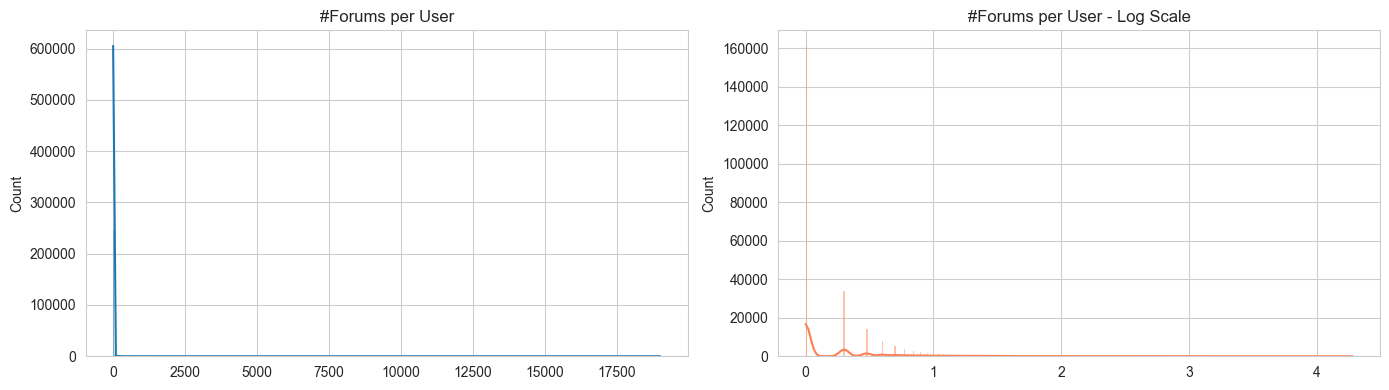

In [5]:
tmp = (
    n_forums_per_user
    .filter(pl.col("UserName").is_not_null())
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

ax = axes[0]
sns.histplot(tmp["n_forums"].to_numpy(), bins=500, kde=True, ax=ax)
ax.set_title("#Forums per User")

ax = axes[1]
sns.histplot(np.log10(tmp["n_forums"].to_numpy()), kde=True, color="coral", ax=ax)
ax.set_title("#Forums per User - Log Scale")

plt.tight_layout()

In [6]:
print(f">>> #Forums Quantiles <<<")
for q in np.arange(0, 1, 0.1).tolist() + [0.95, 0.99]:
    if q == 0 or q == 1: continue

    print(f"q {q:.2f}: {n_forums_per_user['n_forums'].quantile(q)}")

>>> #Forums Quantiles <<<
q 0.10: 1.0
q 0.20: 1.0
q 0.30: 1.0
q 0.40: 1.0
q 0.50: 1.0
q 0.60: 1.0
q 0.70: 2.0
q 0.80: 3.0
q 0.90: 7.0
q 0.95: 16.0
q 0.99: 99.0


We filter pr99 users in terms of the number of forums.

In [7]:
pr95_users = (
    n_forums_per_user
    .filter(pl.col("n_forums") > 16)
    .get_column("UserName")
    .to_numpy()
)
pr99_users = (
    n_forums_per_user
    .filter(pl.col("n_forums") > 99)
    .get_column("UserName")
    .to_numpy()
)
print(f"#Users PR95 {len(pr95_users)} | PR99 {len(pr99_users)}")

df = df.filter(pl.col("UserName").is_in(pr99_users))

#Users PR95 12167 | PR99 2511


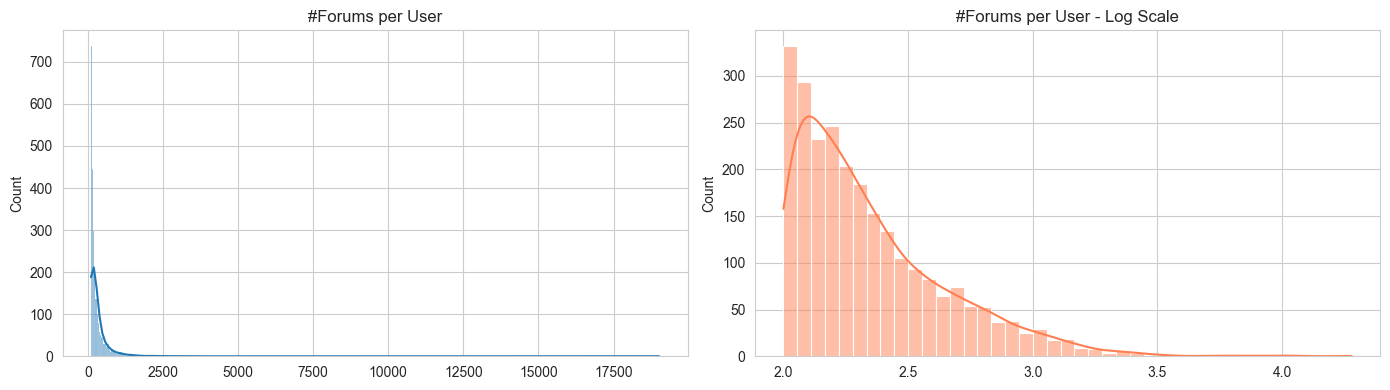

In [8]:
tmp = (
    df
    .group_by("UserName")
    .len()
    .rename({"len": "n_forums"})
)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

ax = axes[0]
sns.histplot(tmp["n_forums"].to_numpy(), bins=500, kde=True, ax=ax)
ax.set_title("#Forums per User")

ax = axes[1]
sns.histplot(np.log10(tmp["n_forums"].to_numpy()), kde=True, color="coral", ax=ax)
ax.set_title("#Forums per User - Log Scale")

plt.tight_layout()

In [9]:
df.shape

(797075, 18)

## 2. Filter Forums by Forum Length

To remove forums without valuable information, we simply choose stats of forum lengths as the determinants. However, this might still cause information loss.

In [10]:
# Use Message as a proxy if RawMarkdown is empty
df = (
    df
    .with_columns(
        pl.when(pl.col("rawmd_len") == 0)
        .then(pl.col("msg_len"))
        .otherwise(pl.col("rawmd_len"))
        .alias("forum_len")
    )
)

len_stats_per_user = (
    df
    .group_by("UserName")
    .agg(
        pl.col("forum_len").min().alias("forum_len_min"),
        pl.col("forum_len").max().alias("forum_len_max"),
        pl.col("forum_len").mean().alias("forum_len_mean"),
        pl.col("forum_len").std().alias("forum_len_std"),
    )
)
len_stats_per_user

UserName,forum_len_min,forum_len_max,forum_len_mean,forum_len_std
str,u32,u32,f64,f64
"""outrunner""",4,4833,221.595376,441.55078
"""ankitkalauni""",1,5679,128.539634,412.389025
"""rimbax""",19,1754,239.161765,246.037252
"""angqx95""",10,6178,273.456311,650.141716
"""kirollosashraf""",9,125,34.78,24.439817
…,…,…,…,…
"""muzammilbaloch""",11,224,93.959954,24.37173
"""jacoporepossi""",5,4663,286.133333,463.135064
"""udbhavpangotra""",7,25009,265.547771,1995.222491


Mean lengths and the corresponding stds look positively correlated. Looking into some examples, we find that some users always post spam forums. One of the phenomenon is to game the system to earn medals, which is just meaningless.

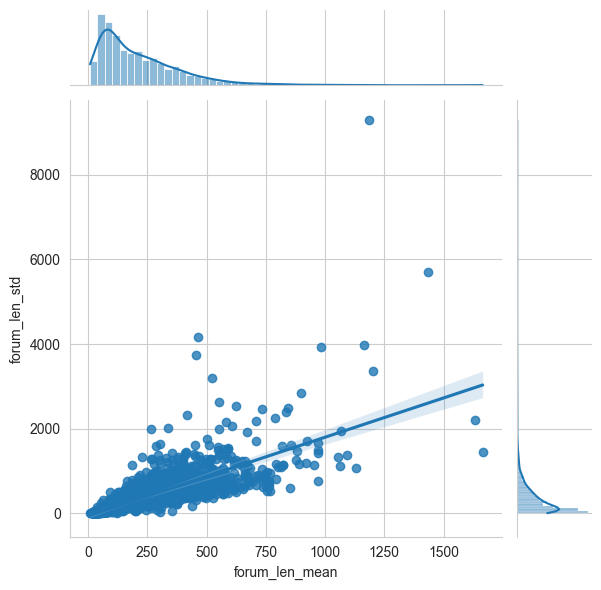

In [11]:
sns.jointplot(data=len_stats_per_user.to_pandas(), x="forum_len_mean", y="forum_len_std", kind="reg")

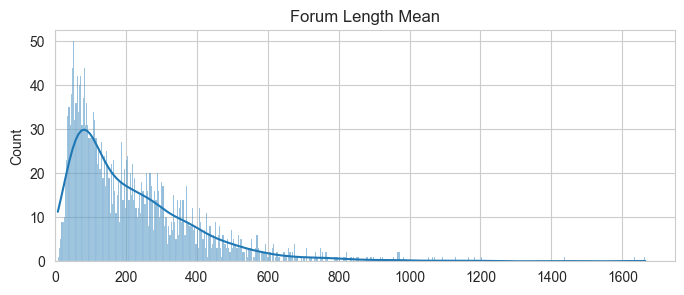

In [12]:
fig, ax = plt.subplots(figsize=(8, 3))
sns.histplot(len_stats_per_user["forum_len_mean"], bins=500, kde=True, ax=ax)
ax.set_title("Forum Length Mean")
ax.set_xlim(0)
plt.show()

After quick investigation, we choose mean and std thresholds to filter the forums.

In [13]:
mean, std = 100, 100
users_to_drop = (
    len_stats_per_user
    .filter((pl.col("forum_len_mean") < mean) | (pl.col("forum_len_std") < std))
    .get_column("UserName")
    .to_numpy()
)
print(f"{len(users_to_drop)} users are dropped.")

df = df.filter(~pl.col("UserName").is_in(users_to_drop))

891 users are dropped.


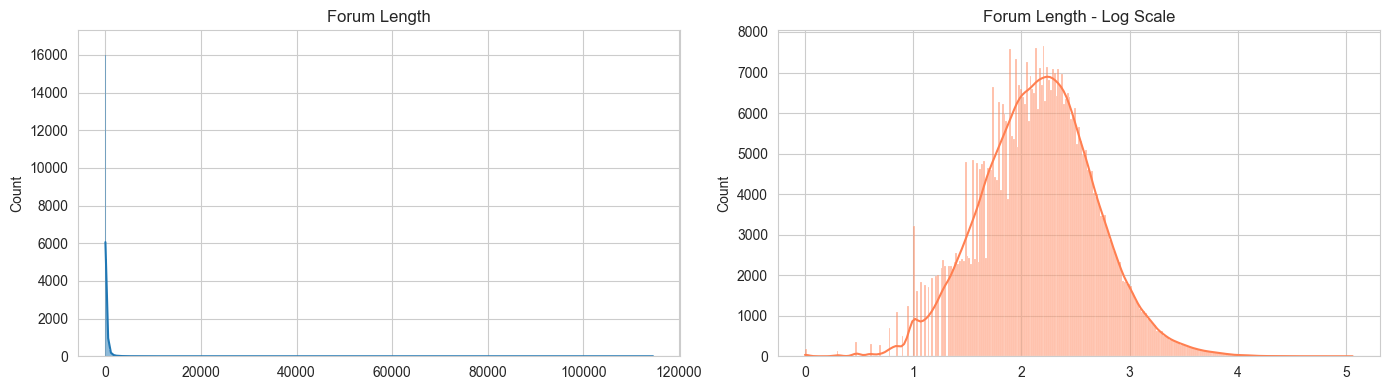

In [14]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 4))

ax = axes[0]
sns.histplot(df["forum_len"].to_numpy(), kde=True, ax=ax)
ax.set_title("Forum Length")

ax = axes[1]
sns.histplot(np.log10(df["forum_len"].to_numpy()), kde=True, color="coral", ax=ax)
ax.set_title("Forum Length - Log Scale")

plt.tight_layout()

After filtering by users, we continue to filter by considering the absolute forum length. 

In [15]:
# tmp = (
#     df
#     .filter((pl.col("forum_len") < 200) & (pl.col("RawMarkdown") != ""))
#     .get_column("RawMarkdown")
#     .sample(n=100)
#     .to_numpy()
# )
# for doc in tmp:
#     print(doc)
#     print("-" * 50)

In [16]:
df = df.filter(pl.col("forum_len") > 200)

As mentioned before, some `RawMarkdown` are broken (all before `2016/10/11`), we'll use `Message` to fill them.

<div class="alert alert-block alert-warning">
    Note that html tags aren't removed for these samples.
</div>

In [17]:
df.filter(pl.col("RawMarkdown") == "")["PostDate"].max()

datetime.datetime(2016, 10, 10, 12, 18, 54)

In [18]:
df = (
    df
    .with_columns(
        pl.when(pl.col("RawMarkdown") != "")
        .then(pl.col("RawMarkdown"))
        .otherwise(pl.col("Message"))
        .alias("text")
    )
)

## 3. Filter Forums by Medals

Finally, we retain forums with at least bronze medals.

In [19]:
# tmp = (
#     df
#     .filter(pl.col("Medal") == "")
#     .get_column("RawMarkdown")
#     .sample(n=100)
#     .to_numpy()
# )
# for doc in tmp:
#     print(doc)
#     print("-" * 50)

In [20]:
df = df.filter(pl.col("Medal") != "")
df.shape

(128404, 20)

In [21]:
df.head()

Id,ForumTopicId,PostDate,ReplyToForumMessageId,Message,RawMarkdown,Medal,MedalAwardDate,UserName,ForumId,KernelId,Title,Slug,CurrentUrlSlug,author_name,forum_url,msg_len,rawmd_len,forum_len,text
i64,i64,datetime[μs],str,str,str,str,str,str,i64,i64,str,str,str,str,str,u32,u32,u32,str
1985,310,2011-03-01 00:40:45,"""""","""Hi Suhendar,<br rel=""nofollow""…","""""","""3""","""07/15/2016""","""salimali""",41,null,"""Benchmarks""","""overfitting""",null,null,"""https://www.kaggle.com/competi…",443,0,443,"""Hi Suhendar,<br rel=""nofollow""…"
1999,310,2011-03-01 00:40:45,"""""","""As demonstrated in an earlier …","""""","""3""","""07/15/2016""","""salimali""",41,null,"""Benchmarks""","""overfitting""",null,null,"""https://www.kaggle.com/competi…",2837,0,2837,"""As demonstrated in an earlier …"
2133,353,2011-04-05 02:39:26,"""""","""Thanks for your thorough quest…","""""","""3""","""07/15/2016""","""jhoward""",42,null,"""Initial Questions about the Ru…","""hhp""",null,null,"""https://www.kaggle.com/competi…",1627,0,1627,"""Thanks for your thorough quest…"
2137,349,2011-04-05 02:48:38,"""""","""Anthony's post is incorrect - …","""""","""3""","""07/15/2016""","""jhoward""",42,null,"""External Data""","""hhp""",null,null,"""https://www.kaggle.com/competi…",257,0,257,"""Anthony's post is incorrect - …"
2206,373,2011-04-05 18:18:11,"""""","""Perhaps a ""length of stay"" gre…","""""","""3""","""07/15/2016""","""chefele""",42,null,"""Can one be at home and hospita…","""hhp""",null,null,"""https://www.kaggle.com/competi…",395,0,395,"""Perhaps a ""length of stay"" gre…"


In [22]:
df = df.drop([
    "Message", "RawMarkdown",
    "msg_len", "rawmd_len", "forum_len",
])

In [23]:
# if CFG.save:
#     df.write_parquet(DATA_PATH / "clean_forums.pqt")

## 4. Filter Forums by Word Couns

To avoid noisy forums, I simply keep forums with word counts greater than GMs' average word count.

In [24]:
df = (
    df
    .with_columns(
        pl.col("text").map_elements(lambda x: len(x.split(" ")), return_dtype=pl.Int32).alias("word_count")
    )
)

gms = [
    "cdeotte",
    "hengck23",
    "cpmpml",
    "ambrosm",
    "tilii7"
]
df.filter(pl.col("UserName").is_in(gms))["word_count"].mean()

107.2336311941511

In [25]:
df = df.filter(pl.col("word_count") > 107)
df["word_count"].mean(), df.shape

(267.3589443501668, (34178, 16))

In [26]:
if CFG.save:
    df.write_parquet(DATA_PATH / "mini_forums.pqt")